In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.model_selection import train_test_split
from scipy.cluster import hierarchy
from sklearn.cluster import AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN

In [3]:
from sklearn.preprocessing import StandardScaler

def preprocess_data(data, drop_columns=None):
    if drop_columns:
        data = data.drop(columns=drop_columns)
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data.select_dtypes(include=[np.number]))
    return scaled_data

In [4]:
data_iris = pd.read_csv("iris.csv")
data_iris.drop_duplicates()
data_iris = data_iris.drop(columns=["species"], axis = 1)
data_iris.head(5)

,sepal_length,sepal_width,petal_length,petal_width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


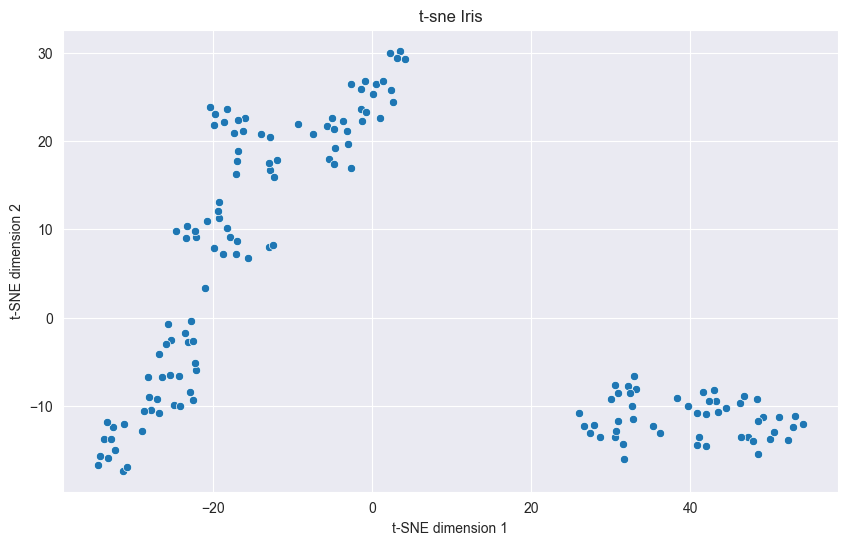

In [5]:
data_iris_tsne = TSNE(n_components=2, learning_rate=200, perplexity=10).fit_transform(X=data_iris)

data_iris_tsne_df = pd.DataFrame(data = data_iris_tsne, columns = ["Dimension1", "Dimension2"])
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data_iris_tsne_df, x='Dimension1', y='Dimension2')
plt.title('t-sne Iris')
plt.xlabel('t-SNE dimension 1')
plt.ylabel('t-SNE dimension 2')
plt.show()

Text(0, 0.5, 'PCA dimension 2')

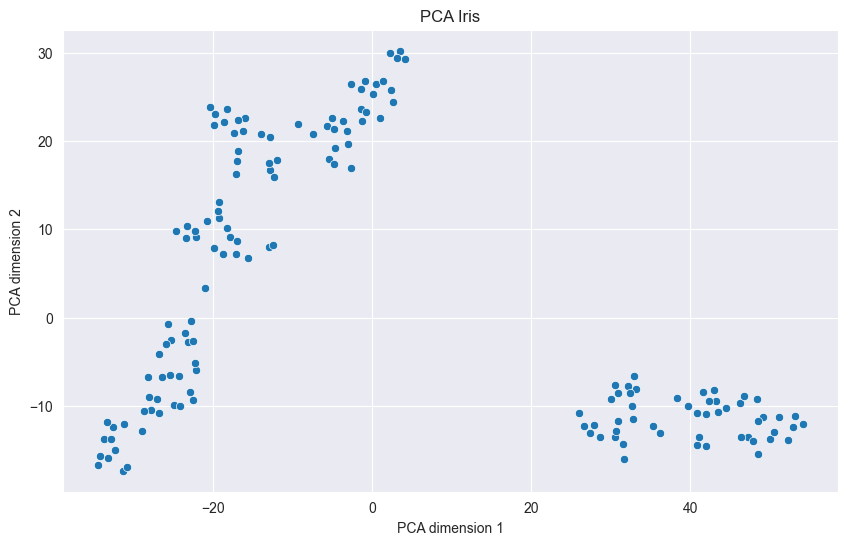

In [6]:
data_iris_pca = PCA(n_components=2).fit_transform(data_iris)

data_iris_pca_df = pd.DataFrame(data = data_iris_pca, columns = ["Dimension1", "Dimension2"])
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data_iris_tsne_df, x='Dimension1', y='Dimension2')
plt.title('PCA Iris')
plt.xlabel('PCA dimension 1')
plt.ylabel('PCA dimension 2')

In [7]:
data_mall = pd.read_csv("Mall_Customers.csv")
data_mall["Gender"] = np.where(data_mall["Gender"] == "Male", 1, 0)
data_mall.head(5)

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,1,19,15,39
1,2,1,21,15,81
2,3,0,20,16,6
3,4,0,23,16,77
4,5,0,31,17,40


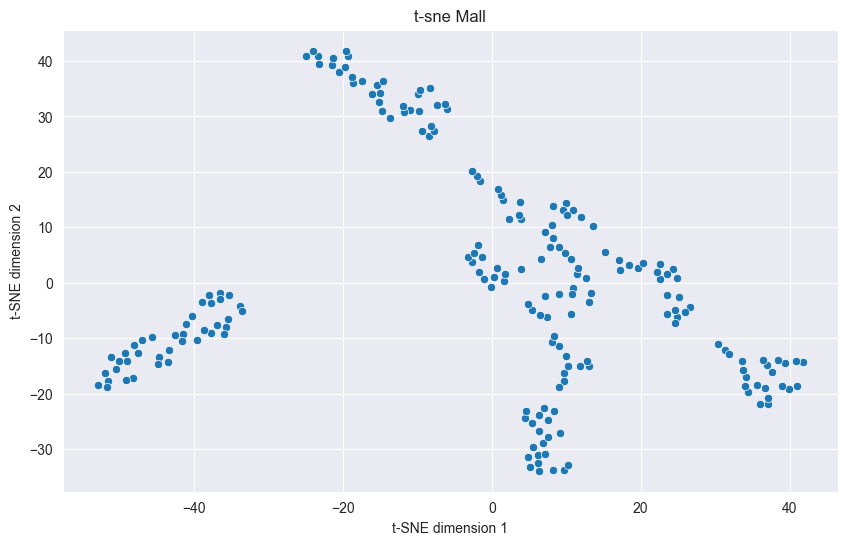

In [8]:
data_mall_tsne = TSNE(n_components=2, learning_rate=200, perplexity=10).fit_transform(X=data_mall)

data_obesity_tsne_df = pd.DataFrame(data = data_mall_tsne, columns = ["Dimension1", "Dimension2"])
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data_obesity_tsne_df, x='Dimension1', y='Dimension2')
plt.title('t-sne Mall')
plt.xlabel('t-SNE dimension 1')
plt.ylabel('t-SNE dimension 2')
plt.show()

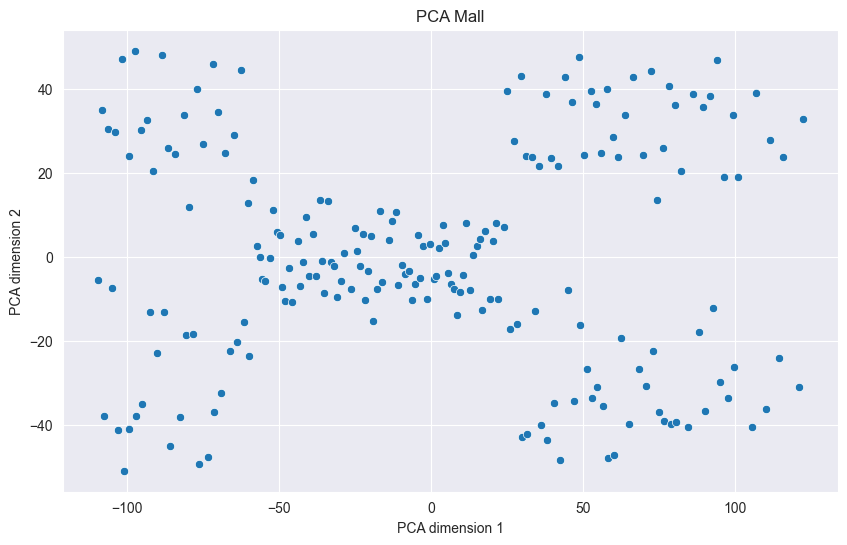

In [9]:
data_mall_pca = PCA(n_components=2).fit_transform(data_mall)

data_mall_pca_df = pd.DataFrame(data = data_mall_pca, columns = ["Dimension1", "Dimension2"])
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data_mall_pca_df, x='Dimension1', y='Dimension2')
plt.title('PCA Mall')
plt.xlabel('PCA dimension 1')
plt.ylabel('PCA dimension 2')
plt.show()

## Кластеризация

In [10]:
def hierarchical_clustering(data, k):
    num_elements = len(data)
    cluster_sizes = list(np.ones(num_elements, dtype=np.int64))
    cluster_indices = list(range(num_elements))
    cluster_distances = {}
    all_cluster_sizes = {c_id: size for c_id, size in zip(cluster_indices, cluster_sizes)}

    # Вычисление начальной матрицы расстояний
    distance_matrix = np.sqrt(np.sum((data[:, None] - data[None, :]) ** 2, axis=2))
    np.fill_diagonal(distance_matrix, np.inf)

    while num_elements > k:
        min_idx = np.argmin(distance_matrix)
        cluster_a, cluster_b = np.unravel_index(min_idx, distance_matrix.shape)
    
        size_a = cluster_sizes[cluster_a]
        size_b = cluster_sizes[cluster_b]
    
        min_distance = distance_matrix[cluster_a, cluster_b]
        cluster_distances[(cluster_indices[cluster_a], cluster_indices[cluster_b])] = min_distance
    
        max_cluster_id = max(cluster_indices)
        for idx in sorted([cluster_a, cluster_b], reverse=True):
            del cluster_sizes[idx]
            del cluster_indices[idx]
    
        alpha_a = (np.array(cluster_sizes) + size_a) / (np.array(cluster_sizes) + size_a + size_b)
        alpha_b = (np.array(cluster_sizes) + size_b) / (np.array(cluster_sizes) + size_a + size_b)
        beta = -np.array(cluster_sizes) / (np.array(cluster_sizes) + size_a + size_b)
    
        distance_matrix = np.delete(distance_matrix, [cluster_a, cluster_b], axis=0)
    
        updated_distances = np.sqrt(
            alpha_a * np.square(distance_matrix[:, cluster_a]) +
            alpha_b * np.square(distance_matrix[:, cluster_b]) +
            beta * (min_distance ** 2)
        )
    
        distance_matrix = np.delete(distance_matrix, [cluster_a, cluster_b], axis=1)
    
        new_distance_matrix = np.zeros((num_elements - 1, num_elements - 1))
        new_distance_matrix[:-1, :-1] = distance_matrix
        new_distance_matrix[-1, -1] = np.inf
        new_distance_matrix[-1, :-1] = updated_distances.T
        new_distance_matrix[:-1, -1] = updated_distances
    
        distance_matrix = new_distance_matrix
    
        cluster_sizes.append(size_a + size_b)
        cluster_indices.append(max_cluster_id + 1)
        all_cluster_sizes[max_cluster_id + 1] = size_a + size_b
        num_elements -= 1

    distance_matrix = np.min(distance_matrix).reshape((1, 1))
    cluster_distances[(cluster_indices[0], cluster_indices[1])] = distance_matrix[0, 0]

    linkage_matrix = np.array([]).reshape((0, 4))
    for k, v in cluster_distances.items():
        row = np.array([k[0], k[1], v,  all_cluster_sizes[k[0]] +  all_cluster_sizes[k[1]]])
        linkage_matrix = np.vstack([linkage_matrix, row])
        
    return linkage_matrix

## Кластеризация ириса

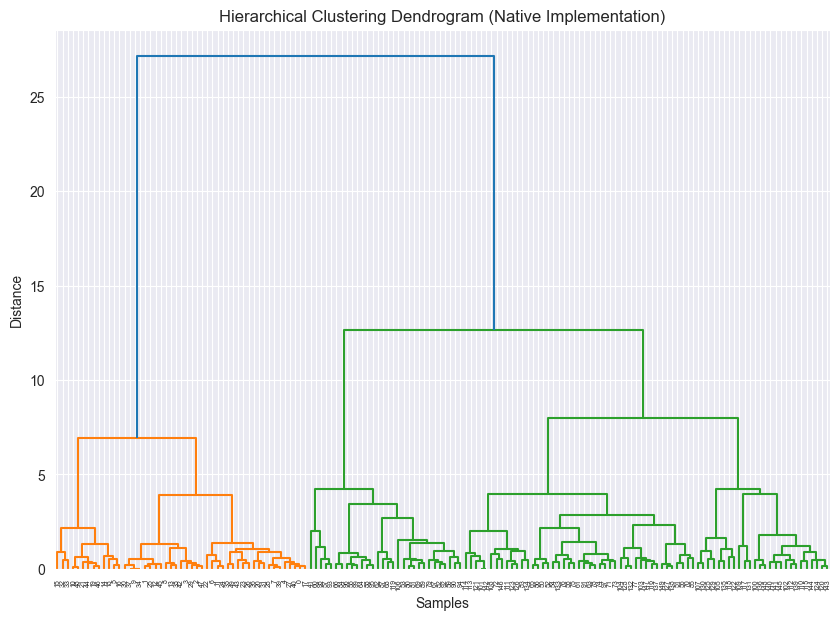

In [11]:
data_iris_scaled = preprocess_data(data_iris)

linkage_matrix = hierarchical_clustering(data_iris_scaled, 2)

plt.figure(figsize=(10, 7))
dendrogram(linkage_matrix)
plt.title("Hierarchical Clustering Dendrogram (Native Implementation)")
plt.xlabel("Samples")
plt.ylabel("Distance")
plt.show()

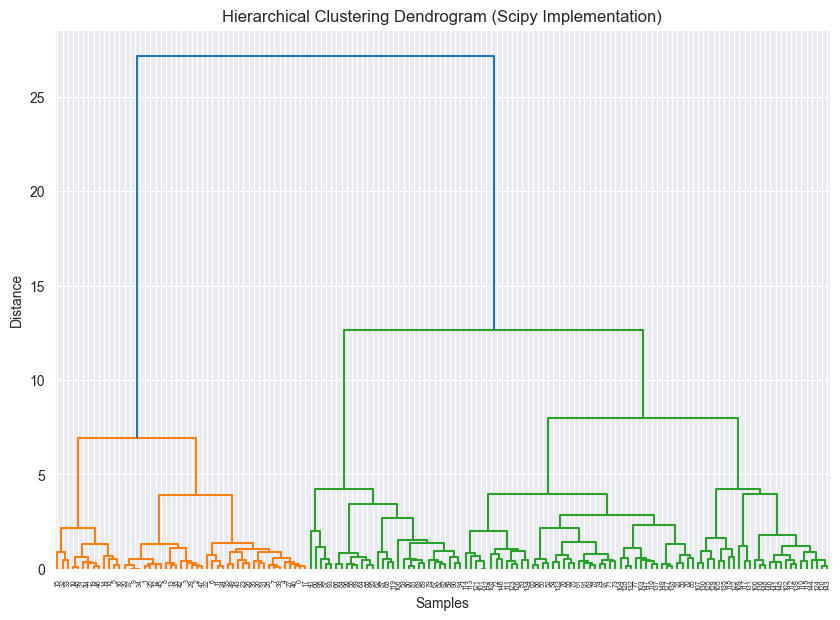

In [12]:
from scipy.cluster import hierarchy as hierarchy_lib

linkage_matrix = hierarchy_lib.linkage(data_iris_scaled, 'ward')

plt.figure(figsize=(10, 7))
dendrogram(linkage_matrix)
plt.title("Hierarchical Clustering Dendrogram (Scipy Implementation)")
plt.xlabel("Samples")
plt.ylabel("Distance")
plt.show()

## Кластеризация Покупателей

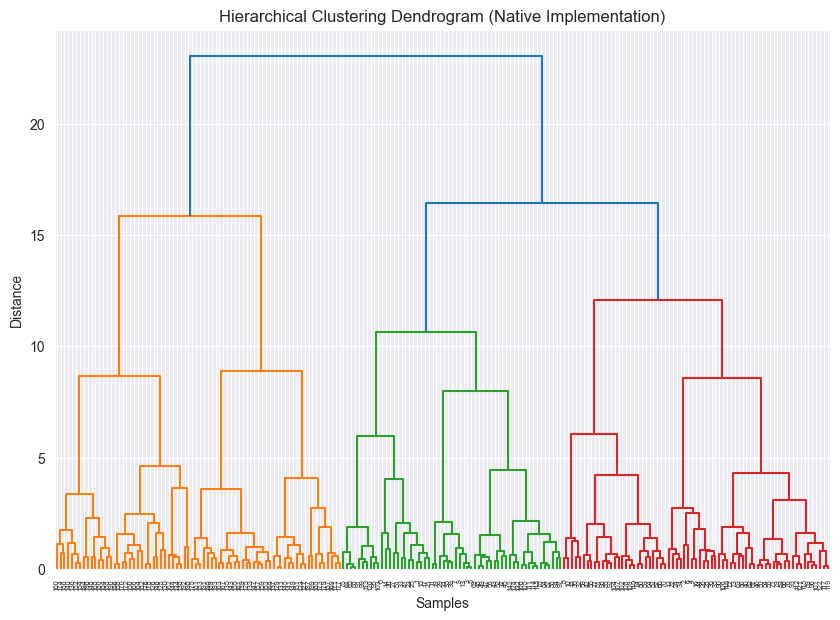

In [13]:
data_mall_scaled = preprocess_data(data_mall)

linkage_matrix = hierarchical_clustering(data_mall_scaled, 2)

plt.figure(figsize=(10, 7))
dendrogram(linkage_matrix)
plt.title("Hierarchical Clustering Dendrogram (Native Implementation)")
plt.xlabel("Samples")
plt.ylabel("Distance")
plt.show()

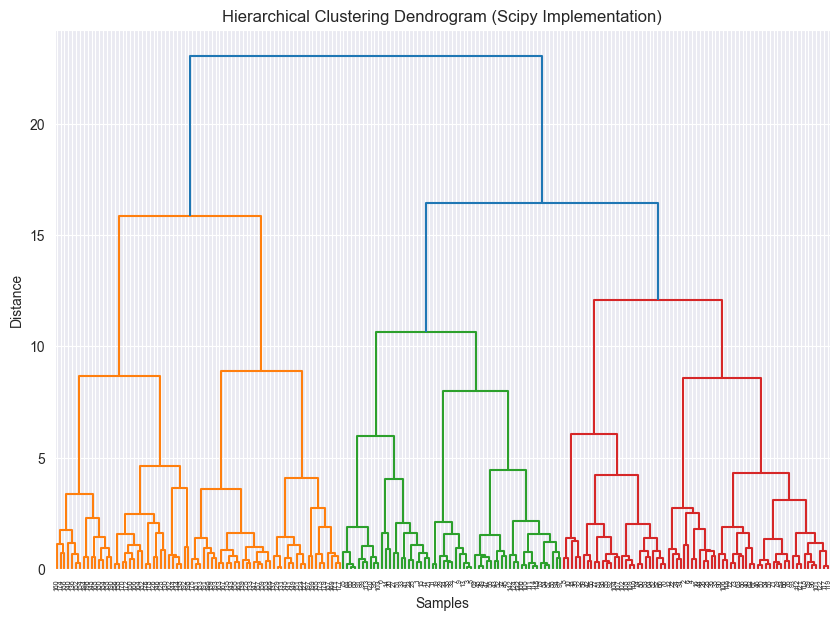

In [14]:
from scipy.cluster import hierarchy as hierarchy_lib

linkage_matrix = hierarchy_lib.linkage(data_mall_scaled, 'ward')

plt.figure(figsize=(10, 7))
dendrogram(linkage_matrix)
plt.title("Hierarchical Clustering Dendrogram (Scipy Implementation)")
plt.xlabel("Samples")
plt.ylabel("Distance")
plt.show()